In [52]:

import habitat_sim
import magnum as mn
import warnings
from habitat.tasks.rearrange.rearrange_sim import RearrangeSim
warnings.filterwarnings('ignore')
from habitat_sim.utils.settings import make_cfg
from matplotlib import pyplot as plt
from habitat_sim.utils import viz_utils as vut
from omegaconf import DictConfig
import numpy as np
from habitat.articulated_agents.robots import FetchRobot
from habitat.config.default import get_agent_config
from habitat.config.default_structured_configs import ThirdRGBSensorConfig, HeadRGBSensorConfig, HeadPanopticSensorConfig
from habitat.config.default_structured_configs import SimulatorConfig, HabitatSimV0Config, AgentConfig
from habitat.config.default import get_agent_config
import habitat
from habitat_sim.physics import JointMotorSettings, MotionType
from omegaconf import OmegaConf
from habitat.articulated_agent_controllers import (
    HumanoidRearrangeController,
    HumanoidSeqPoseController,
)
from habitat.config.default_structured_configs import HumanoidJointActionConfig, HumanoidPickActionConfig



In [2]:
from habitat.config.default_structured_configs import TaskConfig, EnvironmentConfig, DatasetConfig, HabitatConfig
from habitat.config.default_structured_configs import ArmActionConfig, BaseVelocityActionConfig, OracleNavActionConfig
from habitat.core.env import Env
def make_sim_cfg(agent_dict):
    # Start the scene config
    sim_cfg = SimulatorConfig(type="RearrangeSim-v0")
    
    # This is for better graphics
    sim_cfg.habitat_sim_v0.enable_hbao = True
    sim_cfg.habitat_sim_v0.enable_physics = True

    
    # Set up an example scene
    sim_cfg.scene = "data/hab3_bench_assets/hab3-hssd/scenes/103997919_171031233.scene_instance.json"
    sim_cfg.scene_dataset = "data/hab3_bench_assets/hab3-hssd/hab3-hssd.scene_dataset_config.json"
    sim_cfg.additional_object_paths = ['data/objects/ycb/configs/']

    
    cfg = OmegaConf.create(sim_cfg)

    # Set the scene agents
    cfg.agents = agent_dict
    cfg.agents_order = list(cfg.agents.keys())
    return cfg

def make_hab_cfg(agent_dict, action_dict):
    sim_cfg = make_sim_cfg(agent_dict)
    task_cfg = TaskConfig(type="RearrangeEmptyTask-v0")
    task_cfg.actions = action_dict
    env_cfg = EnvironmentConfig()
    dataset_cfg = DatasetConfig(type="RearrangeDataset-v0", data_path="data/hab3_bench_assets/episode_datasets/small_large.json.gz")
    
    
    hab_cfg = HabitatConfig()
    hab_cfg.environment = env_cfg
    hab_cfg.task = task_cfg
    hab_cfg.dataset = dataset_cfg
    hab_cfg.simulator = sim_cfg
    hab_cfg.simulator.seed = hab_cfg.seed

    return hab_cfg

def init_rearrange_env(agent_dict, action_dict):
    hab_cfg = make_hab_cfg(agent_dict, action_dict)
    res_cfg = OmegaConf.create(hab_cfg)
    return Env(res_cfg)

In [40]:
!python -m habitat_sim.utils.datasets_download --uids habitat_test_scenes --data-path data/


git clone --depth 1 --branch main https://huggingface.co/datasets/ai-habitat/habitat_test_scenes.git /home/minwook0008/habitat_re/conversation_setting/data/versioned_data/habitat_test_scenes
Cloning into '/home/minwook0008/habitat_re/conversation_setting/data/versioned_data/habitat_test_scenes'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 11 (delta 0), reused 11 (delta 0), pack-reused 0 (from 0)
Unpacking objects: 100% (11/11), 16.62 KiB | 1.66 MiB/s, done.
Filtering content: 100% (4/4), 105.54 MiB | 20.60 MiB/s, done.
prune: 4 local objects, 0 retained, done.                                       
prune: Deleting objects: 100% (4/4), done.                                      
Dataset (habitat_test_scenes) successfully downloaded.
Source: '/home/minwook0008/habitat_re/conversation_setting/data/versioned_data/habitat_test_scenes'
Symlink: '/home/minwook0008/habitat_re/conversation_

In [41]:
!python -m habitat_sim.utils.datasets_download --uids habitat_test_pointnav_dataset --data-path data/

--2024-07-05 15:06:30--  http://dl.fbaipublicfiles.com/habitat/habitat-test-pointnav-dataset_v1.0.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 99.86.147.55, 99.86.147.64, 99.86.147.94, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|99.86.147.55|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 894623 (874K) [application/zip]
Saving to: ‘/home/minwook0008/habitat_re/conversation_setting/data/habitat-test-pointnav-dataset_v1.0.zip’

habitat-test-pointn 100%[===================>] 873.66K  --.-KB/s    in 0.09s   

2024-07-05 15:06:30 (9.57 MB/s) - ‘/home/minwook0008/habitat_re/conversation_setting/data/habitat-test-pointnav-dataset_v1.0.zip’ saved [894623/894623]

Dataset (habitat_test_pointnav_dataset) successfully downloaded.
Source: '/home/minwook0008/habitat_re/conversation_setting/data/versioned_data/habitat_test_pointnav_dataset_1.0'
Symlink: '/home/minwook0008/habitat_re/conversation_setting/data/datasets/pointnav/habitat

In [3]:
# Define the agent configuration
main_agent_config = AgentConfig()
urdf_path = "data/hab3_bench_assets/humanoids/female_0/female_0.urdf"
main_agent_config.articulated_agent_urdf = urdf_path
main_agent_config.articulated_agent_type = "KinematicHumanoid"
main_agent_config.motion_data_path = "data/hab3_bench_assets/humanoids/female_0/female_0_motion_data_smplx.pkl"


# Define sensors that will be attached to this agent, here a third_rgb sensor and a head_rgb.
# We will later talk about why giving the sensors these names
main_agent_config.sim_sensors = {
    "third_rgb": ThirdRGBSensorConfig(),
    "head_rgb": HeadRGBSensorConfig(),
}

# We create a dictionary with names of agents and their corresponding agent configuration
agent_dict = {"main_agent": main_agent_config}


In [7]:
# Define the actions

action_dict = {
    "humanoid_joint_action": HumanoidJointActionConfig()
}
env = init_rearrange_env(agent_dict, action_dict)

2024-07-05 14:14:57,363 Initializing dataset RearrangeDataset-v0
2024-07-05 14:14:57,365 Rearrange task assets are not downloaded locally, downloading and extracting now...


No data-path provided, defaults to: ./data. Use '--data-path' to specify another location.
Found the existing repo for (replica_cad_dataset): /home/minwook0008/habitat_re/conversation_setting/data/versioned_data/replica_cad_dataset
 checking out v1.6 and pulling changes from repo.
Not replacing data, generating symlink (/home/minwook0008/habitat_re/conversation_setting/data/replica_cad).
Generating symlink (/home/minwook0008/habitat_re/conversation_setting/data/replica_cad).
Found the existing repo for (hab_fetch): /home/minwook0008/habitat_re/conversation_setting/data/versioned_data/hab_fetch
 checking out v2.0 and pulling changes from repo.
Not replacing data, generating symlink (/home/minwook0008/habitat_re/conversation_setting/data/robots/hab_fetch).
Generating symlink (/home/minwook0008/habitat_re/conversation_setting/data/robots/hab_fetch).
Found the existing repo for (ycb): /home/minwook0008/habitat_re/conversation_setting/data/versioned_data/ycb
 checking out main and pulling c

2024-07-05 14:15:00,061 Downloaded and extracted the data.
2024-07-05 14:15:00,073 initializing sim RearrangeSim-v0


Not replacing data, generating symlink (/home/minwook0008/habitat_re/conversation_setting/data/objects/ycb).
Generating symlink (/home/minwook0008/habitat_re/conversation_setting/data/objects/ycb).
Existing data source (rearrange_pick_dataset_v0) version (1.0) is current. Data located: '/home/minwook0008/habitat_re/conversation_setting/data/versioned_data/rearrange_pick_dataset_v0_1.0'. Symblink: '/home/minwook0008/habitat_re/conversation_setting/data/datasets/rearrange_pick/replica_cad/v0'.
Not replacing data, generating symlink (/home/minwook0008/habitat_re/conversation_setting/data/datasets/rearrange_pick/replica_cad/v0).
Generating symlink (/home/minwook0008/habitat_re/conversation_setting/data/datasets/rearrange_pick/replica_cad/v0).
Existing data source (rearrange_dataset_v1) version (1.0) is current. Data located: '/home/minwook0008/habitat_re/conversation_setting/data/versioned_data/rearrange_dataset_v1_1.0'. Symblink: '/home/minwook0008/habitat_re/conversation_setting/data/dat

[14:15:00:595639]:[Warning]:[Metadata] SceneDatasetAttributes.cpp(107)::addNewSceneInstanceToDataset : Dataset : 'hab3-hssd' : Lighting Layout Attributes 'data/hab3_bench_assets/hab3-hssd/scenes/103997919_171031233.scene_instance.json' specified in Scene Attributes but does not exist in dataset, so creating default.
[14:15:00:595841]:[Warning]:[Scene] SemanticScene.h(328)::checkFileExists : ::loadSemanticSceneDescriptor: File../hssd-hab_semantic_lexicon.jsondoes not exist.  Aborting load.
[14:15:00:595995]:[Warning]:[Scene] SemanticScene.cpp(121)::loadSemanticSceneDescriptor : SSD File Naming Issue! Neither SemanticAttributes-provided name : `../hssd-hab_semantic_lexicon.json` nor constructed filename : `../info_semantic.json` exist on disk.
[14:15:00:596012]:[Error]:[Scene] SemanticScene.cpp(137)::loadSemanticSceneDescriptor : SSD Load Failure! File with SemanticAttributes-provided name `../hssd-hab_semantic_lexicon.json` exists but failed to load.
[14:15:00:765280]:[Warning]:[Sim] Si

MeshTools::compile(): ignoring unknown/unsupported attribute Trade::MeshAttribute::Custom(0)
MeshTools::compile(): ignoring unknown/unsupported attribute Trade::MeshAttribute::Custom(1)


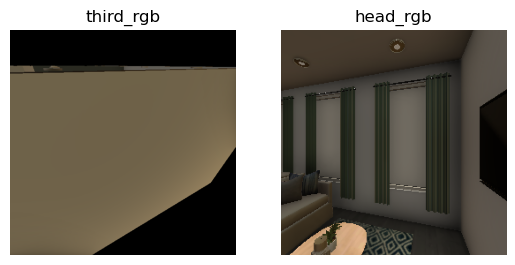

In [8]:
obs = env.reset()
_, ax = plt.subplots(1,len(obs.keys()))

for ind, name in enumerate(obs.keys()):
    ax[ind].imshow(obs[name])
    ax[ind].set_axis_off()
    ax[ind].set_title(name)

In [9]:
sim = env.sim
observations = []
num_iter = 100
pos_delta = mn.Vector3(0.02,0,0)
rot_delta = np.pi / (8 * num_iter)
art_agent = sim.articulated_agent
sim.reset()
# set_fixed_camera(sim)
for _ in range(num_iter):
    # TODO: this actually seems to give issues...
    art_agent.base_pos = art_agent.base_pos + pos_delta
    art_agent.base_rot = art_agent.base_rot + rot_delta
    sim.step({})
    observations.append(sim.get_sensor_observations())


vut.make_video(
    observations,
    "third_rgb",
    "color",
    "robot_tutorial_video",
    open_vid=True,
)

Encoding the video: robot_tutorial_video.mp4 


In [10]:
# TODO: maybe we can make joint_action a subclass of dict, and have a custom function for it
import random
def random_rotation():
    random_dir = mn.Vector3(np.random.rand(3)).normalized()
    random_angle = random.random() * np.pi
    random_rat = mn.Quaternion.rotation(mn.Rad(random_angle), random_dir)
    return random_rat
def custom_sample_humanoid():
    base_transform = mn.Matrix4() 
    random_rot = random_rotation()
    offset_transform = mn.Matrix4.from_(random_rot.to_matrix(), mn.Vector3())
    joints = []
    num_joints = 54
    for _ in range(num_joints):
        Q = random_rotation()
        joints = joints + list(Q.vector) + [float(Q.scalar)]
    offset_trans = list(np.asarray(offset_transform.transposed()).flatten())
    base_trans = list(np.asarray(base_transform.transposed()).flatten())
    random_vec = joints + offset_trans + base_trans
    return {
        "human_joints_trans": random_vec
    }
    

In [11]:
# We can now call the defined actions
observations = []
num_iter = 40
env.reset()
for _ in range(num_iter):
    params = custom_sample_humanoid()
    action_dict = {
        "action": "humanoid_joint_action",
        "action_args": params
    }
    observations.append(env.step(action_dict))
vut.make_video(
    observations,
    "third_rgb",
    "color",
    "robot_tutorial_video",
    open_vid=True,
)

Encoding the video: robot_tutorial_video.mp4 


In [12]:
from habitat.utils.humanoid_utils import MotionConverterSMPLX
PATH_TO_URDF = "/home/minwook0008/habitat_re/habitat-lab/data/humanoids/humanoid_data/female_2/female_2.urdf"
PATH_TO_MOTION_NPZ = "/home/minwook0008/habitat_re/habitat-lab/data/humanoids/humanoid_data/walk_motion/CMU_10_04_stageii.npz"
convert_helper = MotionConverterSMPLX(urdf_path=PATH_TO_URDF)
convert_helper.convert_motion_file(
    motion_path=PATH_TO_MOTION_NPZ,
    output_path=PATH_TO_MOTION_NPZ.replace(".npz", ""),
)

b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
pelvisb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
left_hipb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
left_kneeb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp

In [15]:
env.reset()
motion_path = "/home/minwook0008/habitat_re/habitat-lab/data/humanoids/humanoid_data/walk_motion/CMU_10_04_stageii.pkl" 
# We define here humanoid controller
humanoid_controller = HumanoidSeqPoseController(motion_path)


# Because we want the humanoid controller to generate a motion relative to the current agent, we need to set
# the reference pose
humanoid_controller.reset(env.sim.articulated_agent.base_transformation)
humanoid_controller.apply_base_transformation(env.sim.articulated_agent.base_transformation)


In [16]:
observations = []
for _ in range(humanoid_controller.humanoid_motion.num_poses):
    # These computes the current pose and calculates the next pose
    humanoid_controller.calculate_pose()
    humanoid_controller.next_pose()
    
    # The get_pose function gives as a humanoid pose in the same format as HumanoidJointAction
    new_pose = humanoid_controller.get_pose()
    action_dict = {
        "action": "humanoid_joint_action",
        "action_args": {"human_joints_trans": new_pose}
    }
    observations.append(env.step(action_dict))
    
vut.make_video(
    observations,
    "third_rgb",
    "color",
    "robot_tutorial_video",
    open_vid=True,
)

Encoding the video: robot_tutorial_video.mp4 


In [17]:
# As before, we first define the controller, here we use a special motion file we provide for each agent.
motion_path = "/home/minwook0008/habitat_re/habitat-lab/data/hab3_bench_assets/humanoids/female_0/female_0_motion_data_smplx.pkl" 
# We define here humanoid controller
humanoid_controller = HumanoidRearrangeController(motion_path)

In [18]:
# We reset the controller
env.reset()
humanoid_controller.reset(env.sim.articulated_agent.base_transformation)
observations = []
print(env.sim.articulated_agent.base_pos)
for _ in range(100):
    # This computes a pose that moves the agent to relative_position
    relative_position = env.sim.articulated_agent.base_pos + mn.Vector3(0,0,1)
    humanoid_controller.calculate_walk_pose(relative_position)
    
    # The get_pose function gives as a humanoid pose in the same format as HumanoidJointAction
    new_pose = humanoid_controller.get_pose()
    action_dict = {
        "action": "humanoid_joint_action",
        "action_args": {"human_joints_trans": new_pose}
    }
    observations.append(env.step(action_dict))
    
vut.make_video(
    observations,
    "third_rgb",
    "color",
    "robot_tutorial_video",
    open_vid=True,
)

Vector(-3.46831, 0.180179, -2.9379)
Encoding the video: robot_tutorial_video.mp4 


In [19]:
# We reset the controller
env.reset()
humanoid_controller.reset(env.sim.articulated_agent.base_transformation)
observations = []
print(env.sim.articulated_agent.base_pos)

# Get the hand pose
offset =  env.sim.articulated_agent.base_transformation.transform_vector(mn.Vector3(0, 0.3, 0))
hand_pose = env.sim.articulated_agent.ee_transform(0).translation + offset
for _ in range(100):
    # This computes a pose that moves the agent to relative_position
    hand_pose = hand_pose + mn.Vector3((np.random.rand(3) - 0.5) * 0.1)
    humanoid_controller.calculate_reach_pose(hand_pose, index_hand=0)
    
    # The get_pose function gives as a humanoid pose in the same format as HumanoidJointAction
    new_pose = humanoid_controller.get_pose()
    action_dict = {
        "action": "humanoid_joint_action",
        "action_args": {"human_joints_trans": new_pose}
    }
    observations.append(env.step(action_dict))
    
vut.make_video(
    observations,
    "third_rgb",
    "color",
    "robot_tutorial_video",
    open_vid=True,
)

Vector(-3.62706, 0.180179, -4.91886)
Encoding the video: robot_tutorial_video.mp4 


In [20]:
# Define the actions


action_dict = {
    "humanoid_joint_action": HumanoidJointActionConfig(),
    "humanoid_navigate_action": OracleNavActionConfig(type="OracleNavCoordinateAction", 
                                                      motion_control="human_joints",
                                                      spawn_max_dist_to_obj=1.0),
    "humanoid_pick_obj_id_action": HumanoidPickActionConfig(type="HumanoidPickObjIdAction")
    
}
env = init_rearrange_env(agent_dict, action_dict)

2024-07-05 14:18:07,555 Initializing dataset RearrangeDataset-v0
2024-07-05 14:18:07,557 Rearrange task assets are not downloaded locally, downloading and extracting now...


No data-path provided, defaults to: ./data. Use '--data-path' to specify another location.
Found the existing repo for (replica_cad_dataset): /home/minwook0008/habitat_re/conversation_setting/data/versioned_data/replica_cad_dataset
 checking out v1.6 and pulling changes from repo.
Not replacing data, generating symlink (/home/minwook0008/habitat_re/conversation_setting/data/replica_cad).
Generating symlink (/home/minwook0008/habitat_re/conversation_setting/data/replica_cad).
Found the existing repo for (hab_fetch): /home/minwook0008/habitat_re/conversation_setting/data/versioned_data/hab_fetch
 checking out v2.0 and pulling changes from repo.
Not replacing data, generating symlink (/home/minwook0008/habitat_re/conversation_setting/data/robots/hab_fetch).
Generating symlink (/home/minwook0008/habitat_re/conversation_setting/data/robots/hab_fetch).
Found the existing repo for (ycb): /home/minwook0008/habitat_re/conversation_setting/data/versioned_data/ycb
 checking out main and pulling c

2024-07-05 14:18:09,930 Downloaded and extracted the data.
2024-07-05 14:18:09,941 initializing sim RearrangeSim-v0


Not replacing data, generating symlink (/home/minwook0008/habitat_re/conversation_setting/data/objects/ycb).
Generating symlink (/home/minwook0008/habitat_re/conversation_setting/data/objects/ycb).
Existing data source (rearrange_pick_dataset_v0) version (1.0) is current. Data located: '/home/minwook0008/habitat_re/conversation_setting/data/versioned_data/rearrange_pick_dataset_v0_1.0'. Symblink: '/home/minwook0008/habitat_re/conversation_setting/data/datasets/rearrange_pick/replica_cad/v0'.
Not replacing data, generating symlink (/home/minwook0008/habitat_re/conversation_setting/data/datasets/rearrange_pick/replica_cad/v0).
Generating symlink (/home/minwook0008/habitat_re/conversation_setting/data/datasets/rearrange_pick/replica_cad/v0).
Existing data source (rearrange_dataset_v1) version (1.0) is current. Data located: '/home/minwook0008/habitat_re/conversation_setting/data/versioned_data/rearrange_dataset_v1_1.0'. Symblink: '/home/minwook0008/habitat_re/conversation_setting/data/dat

[14:18:09:992350]:[Warning]:[Metadata] SceneDatasetAttributes.cpp(107)::addNewSceneInstanceToDataset : Dataset : 'hab3-hssd' : Lighting Layout Attributes 'data/hab3_bench_assets/hab3-hssd/scenes/103997919_171031233.scene_instance.json' specified in Scene Attributes but does not exist in dataset, so creating default.
[14:18:09:992484]:[Warning]:[Scene] SemanticScene.h(328)::checkFileExists : ::loadSemanticSceneDescriptor: File../hssd-hab_semantic_lexicon.jsondoes not exist.  Aborting load.
[14:18:09:992671]:[Warning]:[Scene] SemanticScene.cpp(121)::loadSemanticSceneDescriptor : SSD File Naming Issue! Neither SemanticAttributes-provided name : `../hssd-hab_semantic_lexicon.json` nor constructed filename : `../info_semantic.json` exist on disk.
[14:18:09:992681]:[Error]:[Scene] SemanticScene.cpp(137)::loadSemanticSceneDescriptor : SSD Load Failure! File with SemanticAttributes-provided name `../hssd-hab_semantic_lexicon.json` exists but failed to load.
[14:18:10:145160]:[Warning]:[Sim] Si

In [21]:
env.reset()
rom = env.sim.get_rigid_object_manager()
# env.sim.articulated_agent.base_pos = init_pos
# As before, we get a navigation point next to an object id

obj_id = env.sim.scene_obj_ids[0]
first_object = rom.get_object_by_id(obj_id)

object_trans = first_object.translation
print(first_object.handle, "is in", object_trans)
# TODO: unoccluded object did not work
# print(sample)
observations = []
delta = 2.0

object_agent_vec = env.sim.articulated_agent.base_pos - object_trans
object_agent_vec.y = 0
dist_agent_object = object_agent_vec.length()
# Walk towards the object

agent_displ = np.inf
agent_rot = np.inf
prev_rot = env.sim.articulated_agent.base_rot
prev_pos = env.sim.articulated_agent.base_pos
while agent_displ > 1e-9 or agent_rot > 1e-9:
    prev_rot = env.sim.articulated_agent.base_rot
    prev_pos = env.sim.articulated_agent.base_pos
    action_dict = {
        "action": ("humanoid_navigate_action"), 
        "action_args": {
              "oracle_nav_lookat_action": object_trans,
              "mode": 1
          }
    }
    observations.append(env.step(action_dict))
    
    cur_rot = env.sim.articulated_agent.base_rot
    cur_pos = env.sim.articulated_agent.base_pos
    agent_displ = (cur_pos - prev_pos).length()
    agent_rot = np.abs(cur_rot - prev_rot)
    
# Wait
for _ in range(20):
    action_dict = {"action": (), "action_args": {}}
    observations.append(env.step(action_dict))

# Pick object
observations.append(env.step(action_dict))
for _ in range(100):
    
    action_dict = {"action": ("humanoid_pick_obj_id_action"), "action_args": {"humanoid_pick_obj_id": obj_id}}
    observations.append(env.step(action_dict)) 
    
vut.make_video(
    observations,
    "third_rgb",
    "color",
    "robot_tutorial_video",
    open_vid=True,
)

MeshTools::compile(): ignoring unknown/unsupported attribute Trade::MeshAttribute::Custom(0)
MeshTools::compile(): ignoring unknown/unsupported attribute Trade::MeshAttribute::Custom(1)


003_cracker_box_:0000 is in Vector(-5.55847, 0.95434, -2.40326)
Encoding the video: robot_tutorial_video.mp4 


In [24]:
# multi humanoids setting 
# Define the agent configuration
sub_agent_config = AgentConfig()
urdf_path = "data/hab3_bench_assets/humanoids/male_0/male_0.urdf"
sub_agent_config.articulated_agent_urdf = urdf_path
sub_agent_config.articulated_agent_type = "KinematicHumanoid"
sub_agent_config.motion_data_path = "data/hab3_bench_assets/humanoids/male_0/male_0_motion_data_smplx.pkl"


# Define sensors that will be attached to this agent, here a third_rgb sensor and a head_rgb.
# We will later talk about why giving the sensors these names
sub_agent_config.sim_sensors = {
    "third_rgb": ThirdRGBSensorConfig(),
    "head_rgb": HeadRGBSensorConfig(),
}

# We create a dictionary with names of agents and their corresponding agent configuration
# agent_dict = {"main_agent": sub_agent_config}


In [51]:
!python -m habitat_sim.utils.datasets_download --uids replica_cad_dataset replica_cad_baked_lighting --data-path ./


git clone --depth 1 --branch v1.6 https://huggingface.co/datasets/ai-habitat/ReplicaCAD_dataset.git /home/minwook0008/habitat_re/conversation_setting/versioned_data/replica_cad_dataset
Cloning into '/home/minwook0008/habitat_re/conversation_setting/versioned_data/replica_cad_dataset'...
remote: Enumerating objects: 624, done.
remote: Counting objects: 100% (624/624), done.
remote: Compressing objects: 100% (427/427), done.
remote: Total 624 (delta 197), reused 621 (delta 197), pack-reused 0 (from 0)
Receiving objects: 100% (624/624), 785.07 KiB | 559.00 KiB/s, done.
Resolving deltas: 100% (197/197), done.
Note: switching to '6be07e532c83c5799a6e96152f926d07838c2084'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c w

In [33]:
agent_dict = {"agent_0": main_agent_config, "agent_1": sub_agent_config}
action_dict = {
    "humanoid_joint_action": HumanoidJointActionConfig(),
    "humanoid_navigate_action": OracleNavActionConfig(type="OracleNavCoordinateAction", 
                                                      motion_control="human_joints",
                                                      spawn_max_dist_to_obj=1.0),
    "humanoid_pick_obj_id_action": HumanoidPickActionConfig(type="HumanoidPickObjIdAction")
    
}
# env = init_rearrange_env(agent_dict, action_dict)
multi_agent_action_dict = {}
for action_name, action_config in action_dict.items():
    for agent_id in range(2):
        multi_agent_action_dict[f"agent_{agent_id}_{action_name}"] = action_config 
env = init_rearrange_env(agent_dict, multi_agent_action_dict)

2024-07-05 14:41:21,402 Initializing dataset RearrangeDataset-v0
2024-07-05 14:41:21,403 Rearrange task assets are not downloaded locally, downloading and extracting now...


No data-path provided, defaults to: ./data. Use '--data-path' to specify another location.
Found the existing repo for (replica_cad_dataset): /home/minwook0008/habitat_re/conversation_setting/data/versioned_data/replica_cad_dataset
 checking out v1.6 and pulling changes from repo.
Not replacing data, generating symlink (/home/minwook0008/habitat_re/conversation_setting/data/replica_cad).
Generating symlink (/home/minwook0008/habitat_re/conversation_setting/data/replica_cad).
Found the existing repo for (hab_fetch): /home/minwook0008/habitat_re/conversation_setting/data/versioned_data/hab_fetch
 checking out v2.0 and pulling changes from repo.
Not replacing data, generating symlink (/home/minwook0008/habitat_re/conversation_setting/data/robots/hab_fetch).
Generating symlink (/home/minwook0008/habitat_re/conversation_setting/data/robots/hab_fetch).
Found the existing repo for (ycb): /home/minwook0008/habitat_re/conversation_setting/data/versioned_data/ycb
 checking out main and pulling c

2024-07-05 14:41:25,168 Downloaded and extracted the data.
2024-07-05 14:41:25,179 initializing sim RearrangeSim-v0


Not replacing data, generating symlink (/home/minwook0008/habitat_re/conversation_setting/data/objects/ycb).
Generating symlink (/home/minwook0008/habitat_re/conversation_setting/data/objects/ycb).
Existing data source (rearrange_pick_dataset_v0) version (1.0) is current. Data located: '/home/minwook0008/habitat_re/conversation_setting/data/versioned_data/rearrange_pick_dataset_v0_1.0'. Symblink: '/home/minwook0008/habitat_re/conversation_setting/data/datasets/rearrange_pick/replica_cad/v0'.
Not replacing data, generating symlink (/home/minwook0008/habitat_re/conversation_setting/data/datasets/rearrange_pick/replica_cad/v0).
Generating symlink (/home/minwook0008/habitat_re/conversation_setting/data/datasets/rearrange_pick/replica_cad/v0).
Existing data source (rearrange_dataset_v1) version (1.0) is current. Data located: '/home/minwook0008/habitat_re/conversation_setting/data/versioned_data/rearrange_dataset_v1_1.0'. Symblink: '/home/minwook0008/habitat_re/conversation_setting/data/dat

[14:41:25:243608]:[Warning]:[Metadata] SceneDatasetAttributes.cpp(107)::addNewSceneInstanceToDataset : Dataset : 'hab3-hssd' : Lighting Layout Attributes 'data/hab3_bench_assets/hab3-hssd/scenes/103997919_171031233.scene_instance.json' specified in Scene Attributes but does not exist in dataset, so creating default.
[14:41:25:243741]:[Warning]:[Scene] SemanticScene.h(328)::checkFileExists : ::loadSemanticSceneDescriptor: File../hssd-hab_semantic_lexicon.jsondoes not exist.  Aborting load.
[14:41:25:243895]:[Warning]:[Scene] SemanticScene.cpp(121)::loadSemanticSceneDescriptor : SSD File Naming Issue! Neither SemanticAttributes-provided name : `../hssd-hab_semantic_lexicon.json` nor constructed filename : `../info_semantic.json` exist on disk.
[14:41:25:243904]:[Error]:[Scene] SemanticScene.cpp(137)::loadSemanticSceneDescriptor : SSD Load Failure! File with SemanticAttributes-provided name `../hssd-hab_semantic_lexicon.json` exists but failed to load.
[14:41:25:342031]:[Warning]:[Sim] Si

MeshTools::compile(): ignoring unknown/unsupported attribute Trade::MeshAttribute::Custom(0)
MeshTools::compile(): ignoring unknown/unsupported attribute Trade::MeshAttribute::Custom(1)
MeshTools::compile(): ignoring unknown/unsupported attribute Trade::MeshAttribute::Custom(0)
MeshTools::compile(): ignoring unknown/unsupported attribute Trade::MeshAttribute::Custom(1)


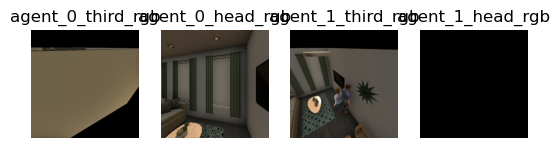

In [34]:
observations = env.reset()
_, ax = plt.subplots(1,len(observations.keys()))

for ind, name in enumerate(observations.keys()):
    ax[ind].imshow(observations[name])
    ax[ind].set_axis_off()
    ax[ind].set_title(name)

In [35]:
env.sim.agents_mgr[1].articulated_agent

In [36]:
env.reset()
rom = env.sim.get_rigid_object_manager()
# env.sim.articulated_agent.base_pos = init_pos
# As before, we get a navigation point next to an object id

obj_id = env.sim.scene_obj_ids[0]
first_object = rom.get_object_by_id(obj_id)

object_trans = first_object.translation
observations = []

# Walk towards the object

agent_displ = np.inf
agent_rot = np.inf
prev_rot = env.sim.agents_mgr[0].articulated_agent.base_rot
prev_pos = env.sim.agents_mgr[0].articulated_agent.base_pos
while agent_displ > 1e-9 or agent_rot > 1e-9:
    prev_rot = env.sim.agents_mgr[0].articulated_agent.base_rot
    prev_pos = env.sim.agents_mgr[0].articulated_agent.base_pos
     
    
    action_dict = {
        "action": ("agent_0_humanoid_navigate_action","agent_1_humanoid_navigate_action"), 
        "action_args": {
              "agent_0_oracle_nav_lookat_action": object_trans,
              "agent_0_mode": 1,
                "agent_1_oracle_nav_lookat_action": object_trans,
               "agent_1_mode": 1
          }
    }
    observations.append(env.step(action_dict))
    
    cur_rot = env.sim.agents_mgr[0].articulated_agent.base_rot
    cur_pos = env.sim.agents_mgr[0].articulated_agent.base_pos
    agent_displ = (cur_pos - prev_pos).length()
    agent_rot = np.abs(cur_rot - prev_rot)
    
    # print(agent_rot, agent_displ)

for _ in range(20):
    action_dict = {"action": (), "action_args": {}}
    observations.append(env.step(action_dict))

# Pick object
observations.append(env.step(action_dict))
for _ in range(100):
        
    action_dict = {"action": ("agent_0_humanoid_pick_obj_id_action", "agent_1_humanoid_pick_obj_id_action"), 
                   "action_args": {
                       "agent_0_humanoid_pick_obj_id": obj_id,
                       "agent_1_humanoid_pick_obj_id": obj_id,
                    }
                   }
    observations.append(env.step(action_dict)) 


vut.make_video(
    observations,
    "agent_1_third_rgb",
    "color",
    "robot_tutorial_video",
    open_vid=True,
)


Encoding the video: robot_tutorial_video.mp4 


In [37]:
vut.make_video(
    observations,
    "agent_0_third_rgb",
    "color",
    "robot_tutorial_video",
    open_vid=True,       
)

Encoding the video: robot_tutorial_video.mp4 


[{'agent_0_third_rgb': array([[[  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0],
          ...,
          [  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0]],
  
         [[  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0],
          ...,
          [  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0]],
  
         [[  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0],
          ...,
          [  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0]],
  
         ...,
  
         [[116,  94,  56],
          [111,  89,  50],
          [112,  89,  50],
          ...,
          [121,  94,  60],
          [117,  90,  57],
          [111,  83,  51]],
  
         [[118,  95,  58],
          [114,  91,  53],
          [112,  88,  51],
          ...,
          [122,  94,  59],
          [121,  94,  60],
          [113,  86,  53]],
  
         [[120,  96,  60],
          [116,  92,  56],
   

In [43]:
import json, gzip
with open("/home/minwook0008/habitat_re/conversation_setting/data/datasets/pointnav/habitat-test-scenes/v1/test/test.json.gz", "rb") as f:
    data = json.load(gzip.open(f))

In [47]:
data['episodes'][0]

{'episode_id': '0',
 'scene_id': 'data/scene_datasets/habitat-test-scenes/skokloster-castle.glb',
 'start_position': [-1.2676633596420288,
  0.2047852873802185,
  12.595427513122559],
 'start_rotation': [0, 0.4536385088584658, 0, 0.8911857849408661],
 'info': {'geodesic_distance': 6.335183143615723, 'difficulty': 'easy'},
 'goals': [{'position': [2.2896811962127686,
    0.11950381100177765,
    16.97636604309082],
   'radius': None}],
 'shortest_paths': None,
 'start_room': None}